## Code outline for Visualizing Patch borders

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.image as mpimg
import torchvision.transforms as transforms
import sys
sys.path.append("/home/jupyter/DIG-In/src/vit_patching/models")
import patch_utils as pu
np.random.seed(42)
import get_patch_ViT16_features_v1 as gp
from lang_sam import LangSAM
from PIL import Image
import torch
import copy

In [2]:
import torchvision.transforms.functional as F

In [3]:
model = LangSAM()

/opt/conda/envs/langsam2/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
Model loaded from /home/jupyter/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [4]:
full_img_root = "/home/jupyter/geode/images"
# new strategy gen images
full_img_gen_root = "/home/jupyter/696DS-data/generated"
objects_file="/home/jupyter/DIG-In/data/seg_low_patches_removed_objects.pkl"
geode_file = "/home/jupyter/DIG-In/data/geode_27_objects.csv"
gen_file = "/home/jupyter/DIG-In/pipeline/data/prompting_2/processed_df_geode_gen.csv"

In [5]:
geode_df = pd.read_csv(geode_file)
gen_df = pd.read_csv(gen_file)

In [6]:
img_size = 224
n_patches = 224 // 16
transforms_list = transforms.Compose([
        gp.CenterCropLongEdge(),
        transforms.Resize(img_size),  # Use dynamic img_size based on the model
        transforms.ToTensor(),
        # TRANSFORM_NORMALIZE
    ])
    
preprocessor1 = transforms_list
preprocessor2 = gp.TRANSFORM_NORMALIZE

In [9]:
img_path = f"{full_img_root}/WestAsia/Turkey/Turkey_car_18287.jpg"
image_pil = Image.open(img_path)
masks, boxes, phrases, logits = model.predict(image_pil, "car")

/opt/conda/envs/langsam2/lib/python3.8/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/opt/conda/envs/langsam2/lib/python3.8/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [13]:
merged_tensor = torch.any(masks, dim=0, keepdim=True)
numpy_mask = merged_tensor.squeeze().numpy()
img, patch_mask = gp.relevant_image_and_patch_mask(image_pil, numpy_mask, 224 //16, preprocessor1, do_obj_seg=True, use_compliment_for_BG=True, use_blackened=False)

In [17]:
img.shape, patch_mask.shape

(torch.Size([3, 224, 224]), torch.Size([1, 63]))

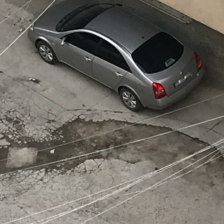

In [18]:
pil_img = F.to_pil_image(img)
pil_img

In [48]:
def border_and_alpha(img, patch_size=16, fill_alpha=True, alpha_filler = 125):
    pil_img = F.to_pil_image(img)
    ni0 = np.array(pil_img)
    if fill_alpha:
        ni = np.ones((224,224,4), dtype='uint8')*255
        ni[:,:,:3] = ni0[:,:,:]
    else:
        ni = ni0
    mask = np.ones((224,224))
    for i in patch_mask[0]:
        if i>0: 
            x = (i-1)//n_patches
            y = (i-1)%n_patches
            mask[x*patch_size: (x+1)*patch_size, y*patch_size: (y+1)*patch_size] = 0.0
            if fill_alpha:
                ni[x*patch_size: (x+1)*patch_size, y*patch_size: (y+1)*patch_size, 3] = alpha_filler
    v_mask = np.zeros(mask.shape)
    h_mask = np.zeros(mask.shape)

    for i in range(1, mask.shape[0]):
        v_mask[i,:] = np.abs(mask[i-1,:]-mask[i,:])

    for j in range(1, mask.shape[1]):
        h_mask[:,j] = np.abs(mask[:, j-1]- mask[:, j])

    border = (v_mask +h_mask >0.5)

    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if border[i][j]==True:
                ni[i,j,0] = 255
                ni[i,j,1] = 0
                ni[i,j,2] = 0
                if fill_alpha:
                    ni[i,j,3] = 255
    return Image.fromarray(ni)

Text(0.5, 1.0, 'border, alpha=125')

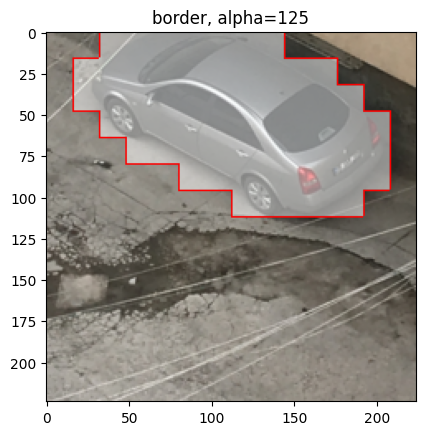

In [50]:
ni2 = border_and_alpha(img)
plt.imshow(ni2)
plt.title(f"border, alpha={125}")

Text(0.5, 1.0, 'border, alpha=0')

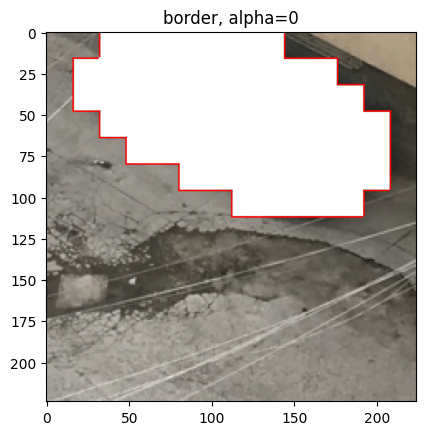

In [51]:
ni2 = border_and_alpha(img, alpha_filler=0)
plt.imshow(ni2)
plt.title(f"border, alpha={0}")

Text(0.5, 1.0, 'border, alpha=255')

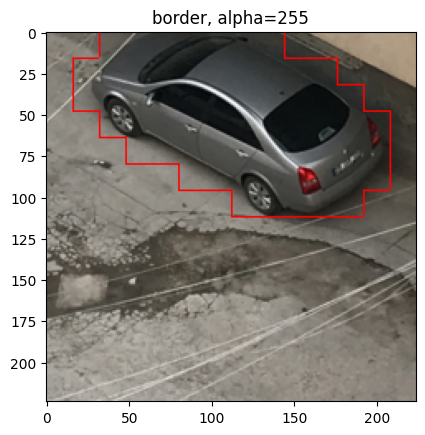

In [52]:
ni2 = border_and_alpha(img, alpha_filler=255)
plt.imshow(ni2)
plt.title(f"border, alpha={255}")